In [1]:
import numpy as np
import pandas as pd

from PIL import Image

from plotting import plot

from utils.ZeoliteData import apply_symmetry, get_transform, get_zeolite, get_data_pore
from utils.dataloading import get_graph_data, get_data

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif',)

In [3]:
zeos = ['MOR','RHO','MFI','ITW']

In [4]:
def get_xyci(n_ats, hoa):
    x = []
    y = []
    y_ci_min = []
    y_ci_max = []
    for i in np.unique(n_ats):
        _x = hoa[n_ats==i]
    
        x.append(i)
        y.append(np.mean(_x))
    
        b,t = np.quantile(_x, [0.05, 0.95])
        y_ci_min.append(b)
        y_ci_max.append(t)

    return np.array(x), np.array(y), np.array(y_ci_min), np.array(y_ci_max)

In [5]:
X = np.load(f'data/MOR/X.npy')
A = pd.read_csv(f'Data/MOR/adj.txt', header=None, sep=' ').values[:,:-1]

In [6]:
l = np.array([18.256,20.534,7.5420])

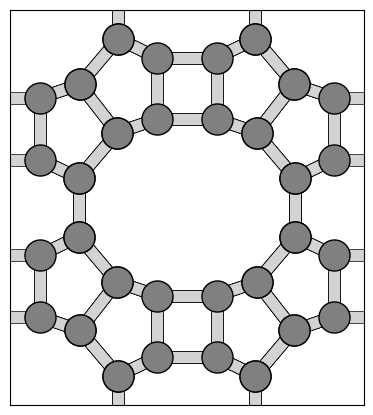

In [7]:
plt.figure(figsize=(l[0]/4, l[1]/4))
plt.scatter(X[:,0], X[:,1], zorder=10, s=500,c='grey',edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i,j] == 1:

            x1 = X[i].copy()
            x2 = X[j].copy()

            diff = x2-x1

            for k in range(len(diff)):

                if diff[k] > 0.5:
                    diff[k] -= 1
                elif diff[k] < -0.5:
                    diff[k] += 1

            x2 = x1 + diff
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c='black', lw=9)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c='lightgray', lw=8)
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('figures/graph.png', dpi=600, bbox_inches='tight')

MOR (5011, 48) 3.0
RHO (1212, 48) 3.0
MFI (3296, 96) 3.0
ITW (762, 24) 1.0


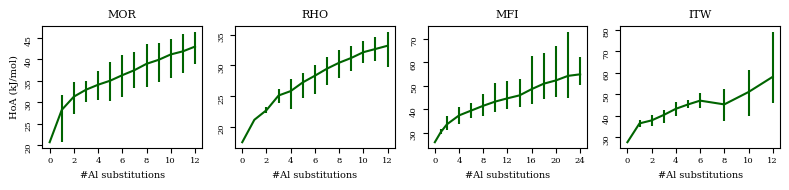

In [8]:
fig, ax = plt.subplots(ncols=4,nrows=1,figsize=(8,2))

for i in range(len(zeos)):

    # idx = i // 2, i % 2
    idx = i
    _ax1 = ax[idx]
    _ax2 = ax[idx]
    atoms, hoa = np.load(f'data/{zeos[i]}/atoms.npy'), np.load(f'data/{zeos[i]}/hoa.npy')
    henry = np.load(f'data/{zeos[i]}/henry.npy')

    n_ats = atoms.sum(1)
    
    sial = (atoms.shape[1] - n_ats.max())/n_ats.max()
    print(zeos[i], atoms.shape, sial)
    
    x1, y1, y_ci_min1, y_ci_max1 = get_xyci(n_ats, hoa)
    

    line1 = _ax1.plot(x1,y1, c='darkgreen')
    
    #_ax.scatter(x,y, c=line[0].get_color(), label=zeo, s=4)
    _ax1.vlines(x1, y_ci_min1, y_ci_max1, colors=line1[0].get_color())
    

    if i == 0:
        _ax1.set_ylabel('HoA (kJ/mol)', fontsize=7)
    _ax1.set_xlabel('#Al substitutions', fontsize=7)
    
    if zeos[i] == 'MFI':
        _ax1.set_xticks(np.arange(0,28,4), np.arange(0,28,4), fontsize=6)
    
    else:
        _ax1.set_xticks(np.arange(0,14,2), np.arange(0,14,2), fontsize=6)
    
    
    _ax1.tick_params(axis='y', labelsize=6, rotation=90)
    
    _ax1.set_title(f'{zeos[i]}', fontsize=8)
    # _ax1.set_ylim(10, 85)
    
    
fig.tight_layout()
fig.savefig('figures/datasetdist.png', dpi=600, bbox_inches='tight', transparent=True)

MOR (5011, 48) 3.0
RHO (1212, 48) 3.0
MFI (3296, 96) 3.0
ITW (762, 24) 1.0


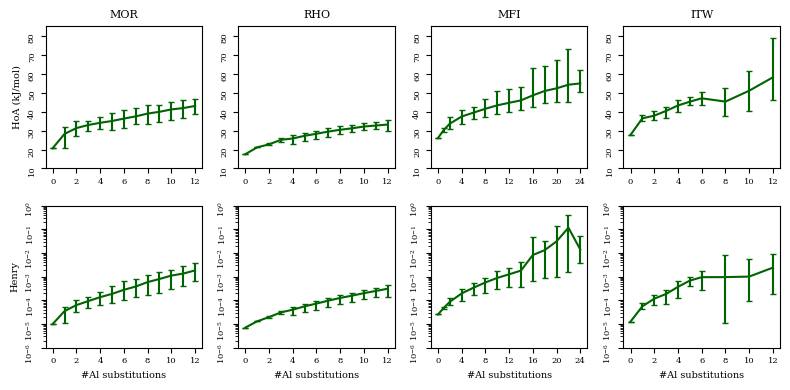

In [9]:
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(8,4))

for i in range(len(zeos)):

    # idx = i // 2, i % 2
    idx = i
    _ax1 = ax[0,idx]
    _ax2 = ax[1,idx]
    atoms, hoa = np.load(f'data/{zeos[i]}/atoms.npy'), np.load(f'data/{zeos[i]}/hoa.npy')
    henry = np.load(f'data/{zeos[i]}/henry.npy')

    n_ats = atoms.sum(1)
    
    sial = (atoms.shape[1] - n_ats.max())/n_ats.max()
    print(zeos[i], atoms.shape, sial)
    
    x1, y1, y_ci_min1, y_ci_max1 = get_xyci(n_ats, hoa)
    x2, y2, y_ci_min2, y_ci_max2 = get_xyci(n_ats, henry)

    # line1 = _ax1.plot(x1,y1, c='darkgreen')
    # line2 = _ax2.plot(x2,y2, c='darkgreen')
    #_ax.scatter(x,y, c=line[0].get_color(), label=zeo, s=4)
    _ax1.errorbar(x1, y1, yerr=(y1-y_ci_min1, y_ci_max1-y1), c='darkgreen',capsize=2)
    _ax2.errorbar(x2, y2, yerr=(y2-y_ci_min2, y_ci_max2-y2), c='darkgreen',capsize=2)
    
    # _ax1.vlines(x1, y_ci_min1, y_ci_max1, colors=line1[0].get_color())
    # _ax2.vlines(x2, y_ci_min2, y_ci_max2, colors=line2[0].get_color())

    if i == 0:
        _ax1.set_ylabel('HoA (kJ/mol)', fontsize=7)
        _ax2.set_ylabel('Henry', fontsize=7)
    _ax2.set_xlabel('#Al substitutions', fontsize=7)
    
    if zeos[i] == 'MFI':
        _ax1.set_xticks(np.arange(0,28,4), np.arange(0,28,4), fontsize=6)
        _ax2.set_xticks(np.arange(0,28,4), np.arange(0,28,4), fontsize=6)
    else:
        _ax1.set_xticks(np.arange(0,14,2), np.arange(0,14,2), fontsize=6)
        _ax2.set_xticks(np.arange(0,14,2), np.arange(0,14,2), fontsize=6)
    
    _ax1.tick_params(axis='y', labelsize=6, rotation=90)
    _ax2.tick_params(axis='y', labelsize=6, rotation=90)
    _ax1.set_title(f'{zeos[i]}', fontsize=8)
    _ax1.set_ylim(10, 85)
    _ax2.set_ylim(1e-6, 1e0)

    _ax2.set_yscale('log')
    
fig.tight_layout()
fig.savefig('figures/datasetdist.pdf', dpi=600, bbox_inches='tight')

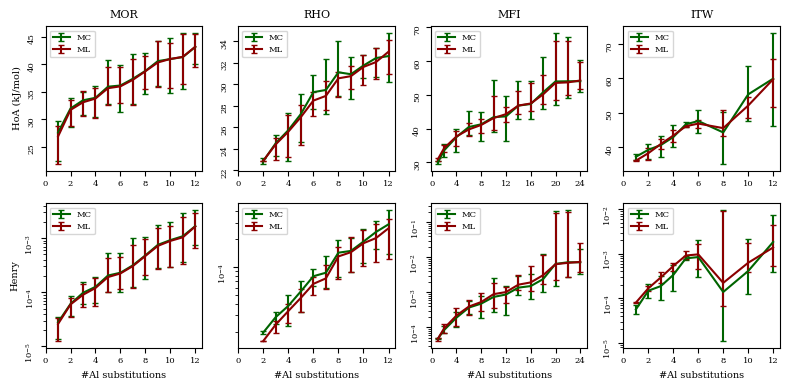

In [10]:
offset = 0.085
fig, ax = plt.subplots(2,4,figsize=(8,4))

for i in range(len(zeos)):

    # idx = i# idx = i // 2, i % 2
    _ax1 = ax[0,i]
    _ax2 = ax[1,i]
    

    atoms = np.load(f'ats_{zeos[i]}.npy').squeeze().astype(float)
    y_pred = np.load(f'pred_{zeos[i]}.npy')
    y_true = np.load(f'true_{zeos[i]}.npy')
    # print(y_pred.shape, y_true.shape)
    # atoms, hoa = np.load(f'data/{zeos[i]}/atoms.npy'), np.load(f'data/{zeos[i]}/hoa.npy')

    n_ats = atoms.sum(1)
    
    sial = (atoms.shape[1] - n_ats.max())/n_ats.max()
#     print(zeos[i], atoms.shape, sial)
    
    x1a, y1a, y1a_ci_min, y1a_ci_max = get_xyci(n_ats, y_true[:,0])
    x1h, y1h, y1h_ci_min, y1h_ci_max = get_xyci(n_ats, y_true[:,1])
    
    x2a, y2a, y2a_ci_min, y2a_ci_max = get_xyci(n_ats, y_pred[:,0])
    x2h, y2h, y2h_ci_min, y2h_ci_max = get_xyci(n_ats, y_pred[:,1])

    
    if zeos[i] == 'MFI':
        x1_1a = x1a# - 2*offset
        x2_1a = x2a# + 2*offset
        x1_1h = x1h# - 2*offset
        x2_1h = x2h# + 2*offset
    
    
    else:
        x1_1a = x1a# - offset
        x2_1a = x2a# + offset
        x1_1h = x1h# - offset
        x2_1h = x2h# + offset

    _ax1.errorbar(x1_1a, y1a, yerr=(y1a-y1a_ci_min, y1a_ci_max-y1a), c='darkgreen',capsize=2, label='MC')
    _ax1.errorbar(x2_1a, y2a, yerr=(y2a-y2a_ci_min, y2a_ci_max-y2a), c='darkred',capsize=2, label='ML')
    _ax2.errorbar(x1_1h, 10**y1h, yerr=(10**y1h-10**y1h_ci_min, 10**y1h_ci_max-10**y1h), c='darkgreen',capsize=2, label='MC')
    _ax2.errorbar(x2_1h, 10**y2h, yerr=(10**y2h-10**y2h_ci_min, 10**y2h_ci_max-10**y2h), c='darkred',capsize=2, label='ML')
       
#     line = _ax.plot(x1,y1, c='darkgreen', label='MC')
#     #_ax.scatter(x,y, c=line[0].get_color(), label=zeo, s=4)
#     _ax.vlines(x1_1, y1_ci_min, y1_ci_max, colors=line[0].get_color())


#     line = _ax.plot(x2,y2, c='darkred', label='ML')
#     #_ax.scatter(x,y, c=line[0].get_color(), label=zeo, s=4)
#     _ax.vlines(x2_1, y2_ci_min, y2_ci_max, colors=line[0].get_color())
    
    if i == 0:
        _ax1.set_ylabel('HoA (kJ/mol)', fontsize=7)
        _ax2.set_ylabel('Henry', fontsize=7)
    _ax2.set_xlabel('#Al substitutions', fontsize=7)

    _ax1.tick_params(axis='y', labelsize=6, rotation=90)
    _ax2.tick_params(axis='y', labelsize=6, rotation=90)
    _ax1.set_title(f'{zeos[i]}', fontsize=8)
    # _ax1.set_ylim(10, 85)
    # _ax2.set_ylim(1e-6, 1e0)

    _ax2.set_yscale('log')
    
    _ax1.legend(fontsize=6, loc='upper left')
    _ax2.legend(fontsize=6, loc='upper left')

    if zeos[i] == 'MFI':
        _ax1.set_xticks(np.arange(0,28,4), np.arange(0,28,4), fontsize=6)
        _ax2.set_xticks(np.arange(0,28,4), np.arange(0,28,4), fontsize=6)
    
    else:
        _ax1.set_xticks(np.arange(0,14,2), np.arange(0,14,2), fontsize=6)
        _ax2.set_xticks(np.arange(0,14,2), np.arange(0,14,2), fontsize=6)

fig.tight_layout()
fig.savefig('figures/mcvsml.pdf', dpi=600, bbox_inches='tight')
fig.savefig('figures/mcvsml.png', dpi=600, bbox_inches='tight')

In [11]:
lims = [(20,50),(20,40),(25, 80),(30,80)]

In [12]:
y_true = np.zeros((0,2))
y_pred = np.zeros((0,2))

for i in range(len(zeos)):
    p = np.load(f'pred_{zeos[i]}.npy')
    t = np.load(f'true_{zeos[i]}.npy')
    y_true = np.concatenate([y_true, t])
    y_pred = np.concatenate([y_pred, p])


In [13]:
y_true.min(), y_true.max(), y_pred.min(), y_pred.max()

(-5.007999420166016, 77.3927001953125, -4.996428966522217, 75.97589874267578)

In [14]:
ytru2 = 10**y_true[:,1]
ytru2.min(), ytru2.max()

(9.81749253769315e-06, 4.820870176362946)

In [15]:
1e0

1.0

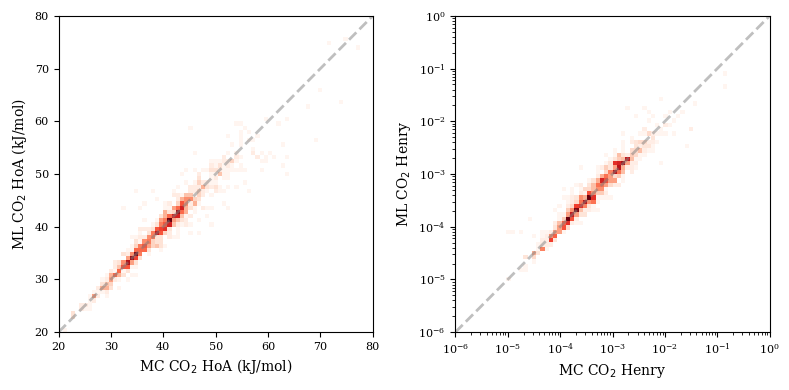

In [16]:
_min, _max = 20,80
_min_, _max_ = 1e-6, 1e0
fig, ax = plt.subplots(ncols=2,figsize=(8,4))
ax[0].hist2d(y_true[:,0], y_pred[:,0], bins=75, cmap='Reds',range=((_min,_max),(_min,_max)),cmin=1)
bins = 10**np.linspace(np.log10(_min_),np.log10(_max_),num=75)
ax[1].hist2d(10**y_true[:,1], 10**y_pred[:,1], bins=bins, cmap='Reds',range=((_min_,_max_),(_min_,_max_)),cmin=1)
ax[0].set_xlim(_min,_max)
ax[0].set_ylim(_min,_max)
ax[1].set_xlim(_min_,_max_)
ax[1].set_ylim(_min_,_max_)
ax[0].plot([_min,_max],[_min,_max], ls="--", c=".5", lw=2, alpha=0.5)
ax[0].set_xlabel(f"MC CO$_2$ HoA (kJ/mol)", fontsize=10)
ax[0].set_ylabel(f"ML CO$_2$ HoA (kJ/mol)", fontsize=10)

ax[1].plot([_min_,_max_],[_min_,_max_], ls="--", c=".5", lw=2, alpha=0.5)
ax[1].set_xlabel(f"MC CO$_2$ Henry", fontsize=10)
ax[1].set_ylabel(f"ML CO$_2$ Henry", fontsize=10)

ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[1].tick_params(axis='both', which='major', labelsize=8)
fig.tight_layout()
fig.savefig('figures/truepred.pdf', dpi=600, bbox_inches='tight');

In [18]:
# fig, ax = plt.subplots(2,2,figsize=(6,6))

# for i in range(len(zeos)):

#     idx = i // 2, i % 2
#     _ax = ax[idx]

#     _min, _max = lims[i]

#     y_pred = np.load(f'pred_{zeos[i]}.npy')
#     y_true = np.load(f'true_{zeos[i]}.npy')
#     #atoms, hoa = np.load(f'data/{zeos[i]}/atoms.npy'), np.load(f'data/{zeos[i]}/hoa.npy')

#     _ax.hist2d(y_true, y_pred, bins=75, range=((_min,_max),(_min,_max)), cmin=0, cmap='Reds')
#     _ax.set_xlim(_min, _max)
#     _ax.set_ylim(_min, _max)
#     _ax.plot(_ax.get_xlim(), _ax.get_ylim(), ls="--", c=".5", lw=2, alpha=0.5)
#     _ax.set_xlabel(f"MCMC CO$_2$ HoA (kJ/mol)", fontsize=8)
#     _ax.set_ylabel(f"ML CO$_2$ HoA (kJ/mol)", fontsize=8)
#     tkz = np.linspace(_min, _max, 5).astype(int)
#     #_ax.set_xticks(_ax.get_yticks())
#     _ax.set_xticks(tkz,tkz)
#     _ax.set_yticks(tkz,tkz)
#     _ax.tick_params(labelsize=6)
#     _ax.set_title(f'{zeos[i]}', fontsize=8)
    
# fig.tight_layout()
# fig.savefig('figures/mcmcvsml_scatter.pdf', dpi=600, bbox_inches='tight')

In [19]:
true_zeos = [np.asarray(Image.open(f'figures/{i}.png')) for i in zeos]


In [20]:
# h, w
ratios = [i.shape[1]/i.shape[0] for i in true_zeos]
ratios

[0.8894409937888199, 1.0, 0.6908517350157729, 0.6930051813471503]

In [21]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
scl = 3

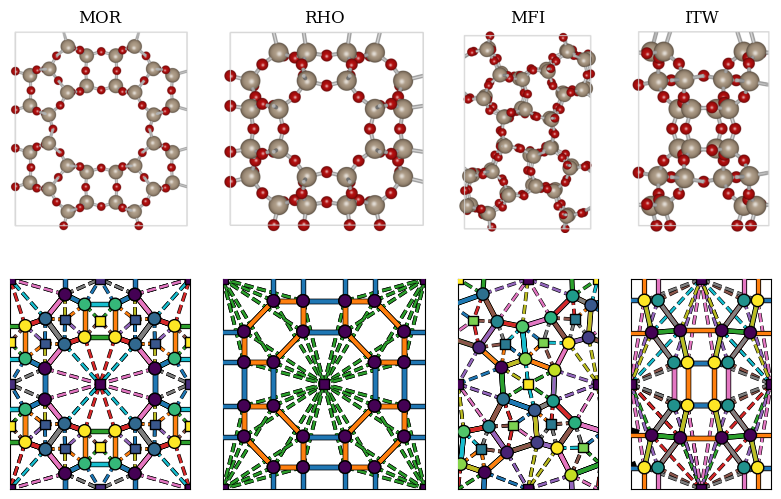

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=4, gridspec_kw={'width_ratios': ratios, 'height_ratios':[1,1]}, figsize=(sum(ratios)*scl, 2*scl))
true_zeos = [np.asarray(Image.open(f'figures/{i}.png')) for i in zeos]

for i in range(len(zeos)):

    true_zeo = np.asarray(Image.open(f'figures/{zeos[i]}.png'))
    ax[0,i].imshow(true_zeo)
    ax[0,i].axis('off')
    ax[0,i].set_title(zeos[i])
    
    plot(zeos[i], ax[1,i])

fig.savefig('figures/zeovsml.pdf', bbox_inches='tight', dpi=1000)
fig.savefig('figures/zeovsml.png', bbox_inches='tight', dpi=1000)

In [24]:
def get_perms(X, ref, tra):    
    permutations = np.zeros((ref.shape[0], X.shape[0]),int)
    for i in range(ref.shape[0]):
        old_X = X.copy()
        new_X = apply_symmetry(old_X, ref[i], tra[i])
        permutations[i] = get_transform(old_X, new_X) 
    return permutations


In [29]:
pred_hoas = np.load('pred_hoas3.npy')
trgt_hoas = np.repeat(np.arange(30,56,1), 10)

In [36]:
mask = trgt_hoas<=56

In [37]:
with open('hoa.dat', 'r') as f:
    lines = f.readlines()[1:]
true_hoas = np.array([float(i.strip().split()[1]) for i in lines])

In [38]:
_pred_hoas = pred_hoas[mask]
_true_hoas = true_hoas[mask]
_trgt_hoas = trgt_hoas[mask]

In [39]:
e = (_pred_hoas-_true_hoas)

In [40]:
offset = 0.05

x1, y1, y1_ci_min, y1_ci_max = get_xyci(_trgt_hoas, _pred_hoas)
x2, y2, y2_ci_min, y2_ci_max = get_xyci(_trgt_hoas, _true_hoas)
x1_1 = x1 - offset
x2_1 = x2 + offset
    

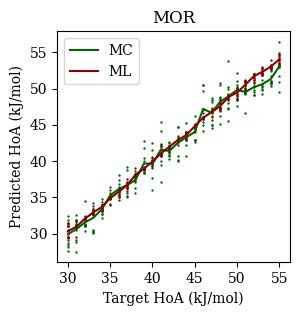

In [42]:
plt.figure(figsize=(3,3))

line = plt.plot(x2,y2, c='darkgreen', label='MC')
# plt.vlines(x2_1, y2_ci_min, y2_ci_max, colors=line[0].get_color())
for j in np.unique(_trgt_hoas):
    _y = _true_hoas[_trgt_hoas==j]
    _x = _trgt_hoas[_trgt_hoas==j]
    plt.scatter(_x, _y, c=line[0].get_color(), s=0.5)
line = plt.plot(x1,y1, c='darkred', label='ML')
# plt.vlines(x1_1, y1_ci_min, y1_ci_max, colors=line[0].get_color())
for j in np.unique(_trgt_hoas):
    _y = _pred_hoas[_trgt_hoas==j]
    _x = _trgt_hoas[_trgt_hoas==j]
    plt.scatter(_x, _y, c=line[0].get_color(), s=0.5)
plt.xticks(np.arange(30,60,5))
plt.xlabel('Target HoA (kJ/mol)')
plt.ylabel('Predicted HoA (kJ/mol)')

plt.legend()    
plt.title('MOR')
plt.savefig('figures/mor_gen.pdf',dpi=450,bbox_inches='tight')
plt.savefig('figures/mor_gen.png',dpi=450,bbox_inches='tight')

In [44]:
ats_mfi = np.load('structures3.npy')
data = get_zeolite('MOR', True)
ref = data['ref']
tra = data['tra']
l = data['l']

atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MOR')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [45]:
perms = get_perms(X, ref, tra)

In [52]:
tr_data = trainloader.dataset.X.numpy()[:,:,0]
te_data = testloader.dataset.X.numpy()[:,:,0]

In [53]:
tr_set = np.zeros((len(ats_mfi), ))
te_set = np.zeros((len(ats_mfi), ))
cnt = 0
for i in ats_mfi:

    added = False

    # if i in tr_data:
    #     added=True
    for perm in perms:
        _i = i[perm]
        if (_i == te_data).all(1).any():
            te_set[cnt] +=1 
        if (_i == tr_data).all(1).any():
            # print(1)
            added=True
            break

    if added:
        tr_set[cnt] += 1

    cnt += 1

In [54]:
trgt_hoas[tr_set.astype(bool)]

array([30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       40])

In [56]:
ats_mfi[tr_set.astype(bool)].sum(1)

array([2., 3., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.,
       4.])

In [55]:
tr_set.mean(), tr_set, tr_set.sum()

(0.1346153846153846,
 array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [50]:
np.mean(e**2), np.mean(np.abs(e))

(2.416372182884433, 1.202454047065148)

(array([ 4.,  4.,  7., 26., 50., 67., 49., 40.,  7.,  6.]),
 array([-4.6683665 , -3.76966615, -2.8709658 , -1.97226545, -1.07356509,
        -0.17486474,  0.72383561,  1.62253597,  2.52123632,  3.41993667,
         4.31863702]),
 <BarContainer object of 10 artists>)

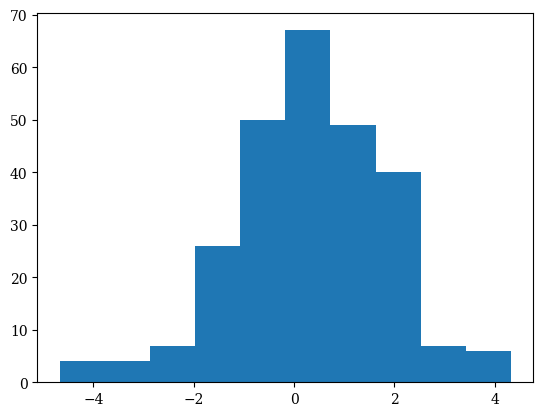

In [51]:
plt.hist(e)

In [77]:
with open('hoa_mfi.dat', 'r') as f:
    lines = f.readlines()[1:]
true_hoas = np.array([float(i.strip().split()[1]) for i in lines])

In [82]:
pred_hoas = np.load('pred_hoas_mfi.npy')
trgt_hoas = np.repeat(np.arange(40,71,1), 10)

In [99]:
mask = trgt_hoas<=60

In [100]:
_pred_hoas = pred_hoas[mask]
_true_hoas = true_hoas[mask]
_trgt_hoas = trgt_hoas[mask]

In [101]:
offset = 0.05

x1, y1, y1_ci_min, y1_ci_max = get_xyci(_trgt_hoas, _pred_hoas)
x2, y2, y2_ci_min, y2_ci_max = get_xyci(_trgt_hoas, _true_hoas)
x1_1 = x1 - offset
x2_1 = x2 + offset

In [102]:
e = (_pred_hoas-_true_hoas)

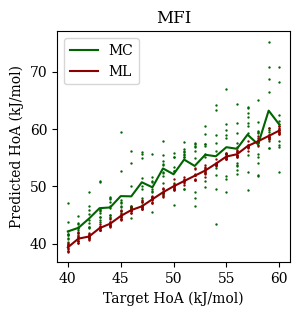

In [103]:
plt.figure(figsize=(3,3))

line = plt.plot(x2,y2, c='darkgreen', label='MC')
# plt.vlines(x2_1, y2_ci_min, y2_ci_max, colors=line[0].get_color())


for j in np.unique(_trgt_hoas):
    _y = _true_hoas[_trgt_hoas==j]
    _x = _trgt_hoas[_trgt_hoas==j]
    plt.scatter(_x, _y, c=line[0].get_color(), s=0.5)
    
# _x = hoa[_trgt_hoas==i]

line = plt.plot(x1,y1, c='darkred', label='ML')
# plt.vlines(x1_1, y1_ci_min, y1_ci_max, colors=line[0].get_color())
for j in np.unique(_trgt_hoas):
    _y = _pred_hoas[_trgt_hoas==j]
    _x = _trgt_hoas[_trgt_hoas==j]
    plt.scatter(_x, _y, c=line[0].get_color(), s=0.5)
plt.xticks(np.arange(40,65,5))
plt.xlabel('Target HoA (kJ/mol)')
plt.ylabel('Predicted HoA (kJ/mol)')

plt.legend()
plt.title('MFI')
plt.savefig('figures/mfi_gen.png',dpi=450,bbox_inches='tight')
plt.savefig('figures/mfi_gen.pdf',dpi=450,bbox_inches='tight')

(array([ 82., 294., 283., 291., 284., 572., 260., 292., 284., 324.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

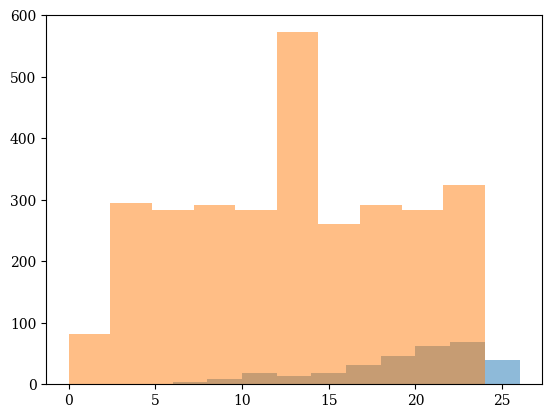

In [117]:
plt.hist(ats_mfi.sum(-1), alpha=.5)
plt.hist(tr_data.sum(-1), alpha=.5)
# ats_mfi.sum(-1)

In [104]:
ats_mfi = np.load('structures_mfi.npy')
data = get_zeolite('MFI', True)
ref = data['ref']
tra = data['tra']
l = data['l']

atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MFI')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [105]:
perms = get_perms(X, ref, tra)

In [106]:
tr_data = trainloader.dataset.X.numpy()[:,:,0]

In [107]:
(ats_mfi[0] == tr_data).all(1).any()

False

In [108]:
tr_set = np.zeros((len(ats_mfi), ))
cnt = 0
for i in ats_mfi:

    added = False

    # if i in tr_data:
    #     added=True
    for perm in perms:
        _i = i[perm]
        if (_i == tr_data).all(1).any():
            print(1)
            added=True
            break

    if added:
        tr_set[cnt] += 1

    cnt += 1

In [109]:
tr_set.mean()

0.0

In [110]:
np.mean(e**2), np.mean(np.abs(e))

(21.424955957512818, 3.629237397838774)

(array([ 1.,  3., 10., 20., 52., 72., 32., 12.,  7.,  1.]),
 array([-16.69852419, -13.96773012, -11.23693605,  -8.50614198,
         -5.77534791,  -3.04455384,  -0.31375977,   2.4170343 ,
          5.14782837,   7.87862245,  10.60941652]),
 <BarContainer object of 10 artists>)

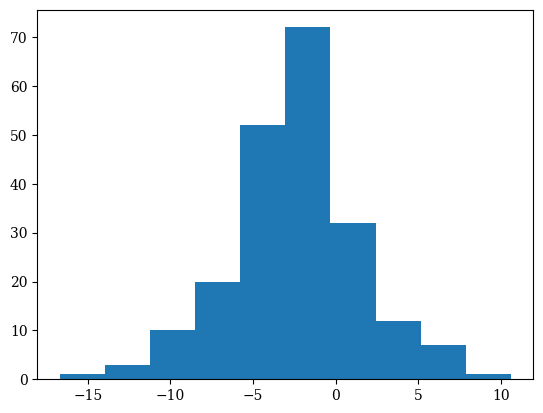

In [111]:
plt.hist(e)